# Aula 11: Análise de sentimentos IMDB usand BERT

Nome: Marcos Piau Vieira

Referências úteis:
- https://jaketae.github.io/category/common-sense/
- https://huggingface.co/transformers/model_doc/auto.html

# Instalacão de pacotes e imports básicos

In [ ]:
!pip3 install -q neptune-client pytorch-lightning torchmetrics pyeer tokenizers transformers sentencepiece deepspeed
!sudo apt-get install tree

     |████████████████████████████████| 245kB 15.1MB/s 
     |████████████████████████████████| 808kB 21.7MB/s 
     |████████████████████████████████| 276kB 24.8MB/s 
     |████████████████████████████████| 614kB 58.8MB/s 
     |████████████████████████████████| 3.3MB 56.8MB/s 
     |████████████████████████████████| 2.3MB 55.2MB/s 
     |████████████████████████████████| 1.2MB 48.8MB/s 
     |████████████████████████████████| 450kB 58.4MB/s 
     |████████████████████████████████| 829kB 46.8MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 163kB 71.1MB/s 
     |████████████████████████████████| 112kB 69.9MB/s 
     |████████████████████████████████| 10.6MB 51.7MB/s 
     |████████████████████████████████| 645kB 40.4MB/s 
     |████████████████████████████████| 901kB 54.8MB/s 
     |████████████████████████████████| 225kB 59.8MB/s 
     |████████████████████████████████| 112kB 53.0MB/s 
     |████████████████████████████████| 14.9MB 3

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Diretório base para salvar os checkpoints:

In [ ]:
CKPT_DIR = '/content/drive/MyDrive/IA376I_1S2021/aula_11/checkpoints/'
# CKPT_DIR = './checkpoints/'
!ls -lht {CKPT_DIR}

total 55G
-rw------- 1 root root 4.6G Jun 16 18:58 'exp_uuid=1d40107d-eaea-4a52-99d1-3bcad7485407-epoch=9-train_epoch_f1=0.0000-train_epoch_accuracy=0.9914-val_epoch_f1=0.0000-val_epoch_accuracy=0.9600.ckpt'
-rw------- 1 root root 4.6G Jun 16 17:53 'exp_uuid=c3d36aa5-af91-420a-bb1d-977cb357ee15-epoch=6-train_epoch_f1=0.0000-train_epoch_accuracy=0.9814-val_epoch_f1=0.0000-val_epoch_accuracy=0.9600.ckpt'
-rw------- 1 root root 4.6G Jun 16 17:16 'exp_uuid=8c1be1e5-b1ce-407d-8568-48a6d863c65e-epoch=6-train_epoch_f1=0.0000-train_epoch_accuracy=0.9800-val_epoch_f1=0.0000-val_epoch_accuracy=0.9500.ckpt'
-rw------- 1 root root 4.6G Jun 16 16:31 'exp_uuid=7c187990-4797-41d6-950e-d5e1c2354b95-epoch=7-train_epoch_f1=0.0000-train_epoch_accuracy=0.9643-val_epoch_f1=0.0000-val_epoch_accuracy=0.9400.ckpt'
-rw------- 1 root root 4.6G Jun 16 08:09 'exp_uuid=dca65b94-c76b-44eb-abf7-e046b8e80ba2-epoch=1-train_epoch_f1=0.0000-train_epoch_accuracy=0.8900-val_epoch_f1=0.0000-val_epoch_accuracy=0.9500.ckpt'


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

import os
import copy
import gc
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import uuid
from pathlib import Path
# os.environ['NEPTUNE_API_TOKEN'] = 'Favor não usar por engano'

# Deixa tudo replicável
import pytorch_lightning as pl
pl.seed_everything(123)

Global seed set to 123


123

GPU:

In [ ]:
!nvidia-smi

Wed Jun 16 19:28:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2021-06-16 15:58:50--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.2.19, 104.26.3.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/imdb_sample.tgz [following]
--2021-06-16 15:58:50--  https://files.fast.ai/data/examples/imdb_sample.tgz
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K   903KB/s    in 0.6s    

2021-06-16 15:58:51 (903 KB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



Head do arquivo:

In [ ]:
!head imdb_sample/texts.csv

label,text,is_valid
negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly

Carregando no pandas e fazendo pré processamento (remoção de tags HTML):

In [ ]:
import pandas as pd
# avoids accidental setting with copy 
pd.options.mode.chained_assignment = 'raise'
from sklearn.model_selection import train_test_split


df = pd.read_csv('imdb_sample/texts.csv')

html_tag_pattern = re.compile('<.*?>')
remove_html_tags = lambda x: re.sub(html_tag_pattern, ' ', x)
df['text'] = df['text'].map(remove_html_tags)


df['is_valid'] = df['is_valid'].astype(bool)
df['part'] = np.where(df['is_valid'], 'test', 'train')


label_map = {'positive': 1, 'negative': 0}
df['label_int'] = df['label'].map(label_map)

idx_train, idx_val = train_test_split(
    df[~df['is_valid']].index.to_numpy(copy=True), test_size=100,
    shuffle=True, stratify=df.loc[~df['is_valid'], 'label_int']
)

df.loc[idx_train, 'part'] = 'train'
df.loc[idx_val, 'part'] = 'val'
del idx_train, idx_val


df.head()

,label,text,is_valid,part,label_int
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False,train,0
1,positive,This is a extremely well-made film. The acting...,False,val,1
2,negative,Every once in a long while a movie will come a...,False,train,0
3,positive,Name just says it all. I watched this movie wi...,False,train,1
4,negative,This movie succeeds at being one of the most u...,False,val,0


# Tokenizer

A biblioteca `transformers` é bem completa e possui algumas formas de fazer as mesmas tarefas. Aqui veremos algumas opções de formas de uso do tokenizer.

In [ ]:
from transformers import AutoTokenizer, AutoModel 
from transformers import BertTokenizer, BertTokenizerFast
from transformers import BertForTokenClassification, BertForTokenClassification, BertModel

## Instanciamento dos objetos

In [ ]:
# classe BertTokenizer: implementação original do tokenizador
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# BertTokenizerFast: implementação "fast", própria da HuggingFace
bert_tokenizer_fast = BertTokenizerFast.from_pretrained('bert-base-uncased')

# AutoTokenizer: mesma classe pode ser usada para tokenizadores de diferentes modelos
# pelo que entendi, retorna a versão "fast" se houver
bert_auto_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

## Compara tempo de execução e outputs retornados

In [ ]:
encoded = dict()

In [ ]:
%%time
encoded['bert_tokenizer'] = bert_tokenizer(df['text'].tolist())

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5.96 s, sys: 0 ns, total: 5.96 s
Wall time: 5.99 s


In [ ]:
%%time
encoded['bert_tokenizer_fast'] = bert_tokenizer_fast(df['text'].tolist())

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 1.22 s, sys: 93.7 ms, total: 1.32 s
Wall time: 746 ms


In [ ]:
%%time
encoded['bert_auto_tokenizer'] = bert_auto_tokenizer(df['text'].tolist())

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 1.2 s, sys: 77.4 ms, total: 1.28 s
Wall time: 732 ms




O que tem num output (dict com chaves expostas como atributos):

In [ ]:
encoded['bert_tokenizer'].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Outputs batem? SIM:

In [ ]:
assert encoded['bert_tokenizer'] == encoded['bert_tokenizer_fast']
assert encoded['bert_tokenizer'] == encoded['bert_auto_tokenizer']

Os outputs de todos tokenizers são iguais, mas as implementacões "fast" (conforme o próprio nome já diz) são mais rápidas; vou utilizar o AutoTokenizer porque além de ser mais rápido fica mais fácil para utilizar em outros tipos de modelo, pois só precisamos trocar o prefixo que identifica o modelo.

## Comprimento das sentenças

O comprimento máximo das sentenças no modelo BERT é de 512, mas fica aqui uam breve análise dos comprimentos das sentenças no nosso dataset.

count    1000.00
mean      315.36
std       232.65
min        45.00
25%       165.00
50%       235.00
75%       385.00
max      1635.00
dtype: float64

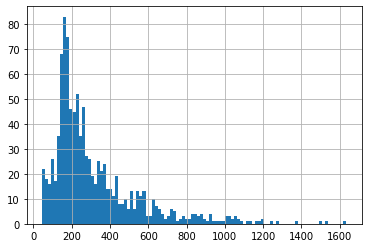

In [ ]:
lengths = pd.Series(map(len, encoded['bert_auto_tokenizer'].input_ids))
display(lengths.describe().round(2))
lengths.hist(bins=100)
del lengths

# Dataset

Iremos fazer tokenização no `__getitem__`, mas sem travar o comprimento máximo; para conseguirmos fazer isso sem precisar de código adicional, os valores retornados pelo dataset são listas e não tensores; os dados são transformados em tensores no momento de fazer o "collate" do batch. O comprimento igual entre todos exemplos será garantido pelo `DataCollatorWithPadding`.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding, AutoTokenizer

class AutoModelDataset(Dataset):
    def __init__(
        self,
        texts,
        labels,
        model_prefix='bert-base-uncased',
        max_length=None
        ):
        assert len(texts) == len(labels)
        self.texts = texts
        self.labels = labels
        self.model_prefix = model_prefix
        self.tokenizer = AutoTokenizer.from_pretrained(model_prefix)
        self.max_length = max_length or self.tokenizer.model_max_length

        # Collate to max length in batch
        self.collator = DataCollatorWithPadding(
            tokenizer = self.tokenizer,
            padding='longest',
            max_length=self.max_length)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        out = self.tokenizer(self.texts[idx],truncation='longest_first',
                             max_length=self.max_length)
        # after collation, 'label' key is renamed to 'labels'
        out['label'] = self.labels[idx]
        return out

# Check de dataset

In [ ]:
debug_dataset = AutoModelDataset(
    texts=df[~df['is_valid']]['text'].tolist(),
    labels=df[~df['is_valid']]['label_int'].tolist(),
    model_prefix='bert-base-uncased'
)

debug_dataloader = DataLoader(debug_dataset, batch_size=10, shuffle=False,
                              collate_fn=debug_dataset.collator)

Texto original:

In [ ]:
debug_dataset.texts[0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

O que sai do tokenizer (acontece dentro do dataset):

In [ ]:
debug_dataset.tokenizer(debug_dataset.texts[0])

{'input_ids': [101, 4895, 1011, 1038, 10559, 4691, 1011, 19337, 2666, 12423, 999, 12669, 4575, 2987, 1005, 1056, 2130, 2298, 2014, 5156, 2566, 2102, 8840, 12423, 2969, 1999, 2023, 1010, 2029, 5373, 3084, 2033, 9641, 2014, 8467, 16356, 2100, 3772, 8040, 11039, 6799, 1012, 2524, 2000, 2903, 2016, 2001, 1996, 3135, 2006, 2023, 3899, 1012, 4606, 4901, 1047, 4179, 1024, 2054, 2785, 1997, 5920, 4440, 2038, 2010, 2476, 2042, 2006, 1029, 2040, 17369, 1012, 1012, 1012, 7221, 25290, 999, 999, 999, 2633, 2023, 2001, 2856, 2011, 1996, 3124, 2040, 2106, 2502, 10720, 1029, 2442, 2022, 1037, 15712, 1997, 3557, 4665, 1011, 5365, 2806, 1012, 15854, 7245, 2546, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Tokens:

In [ ]:
print(debug_dataset.tokenizer.tokenize(debug_dataset.texts[0]))

['un', '-', 'b', '##lee', '##ping', '-', 'bel', '##ie', '##vable', '!', 'meg', 'ryan', 'doesn', "'", 't', 'even', 'look', 'her', 'usual', 'per', '##t', 'lo', '##vable', 'self', 'in', 'this', ',', 'which', 'normally', 'makes', 'me', 'forgive', 'her', 'shallow', 'tick', '##y', 'acting', 'sc', '##ht', '##ick', '.', 'hard', 'to', 'believe', 'she', 'was', 'the', 'producer', 'on', 'this', 'dog', '.', 'plus', 'kevin', 'k', '##line', ':', 'what', 'kind', 'of', 'suicide', 'trip', 'has', 'his', 'career', 'been', 'on', '?', 'who', '##osh', '.', '.', '.', 'ban', '##zai', '!', '!', '!', 'finally', 'this', 'was', 'directed', 'by', 'the', 'guy', 'who', 'did', 'big', 'chill', '?', 'must', 'be', 'a', 'replay', 'of', 'jones', '##town', '-', 'hollywood', 'style', '.', 'woo', '##off', '##f', '!']


Se formos fazer o decoding ("detokenizar", ou converter de ids pra tokens) (repare que tudo volta lower case):

In [ ]:
debug_dataset.tokenizer.decode(debug_dataset.tokenizer.encode(debug_dataset.texts[0]), skip_special_tokens=True)

"un - bleeping - believable! meg ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. hard to believe she was the producer on this dog. plus kevin kline : what kind of suicide trip has his career been on? whoosh... banzai!!! finally this was directed by the guy who did big chill? must be a replay of jonestown - hollywood style. wooofff!"

Podemos incluir tokens especiais no decoding (tokens [CLS] e [SEP] aparecem):

In [ ]:
debug_dataset.tokenizer.decode(debug_dataset.tokenizer.encode(debug_dataset.texts[0]), skip_special_tokens=False)

"[CLS] un - bleeping - believable! meg ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. hard to believe she was the producer on this dog. plus kevin kline : what kind of suicide trip has his career been on? whoosh... banzai!!! finally this was directed by the guy who did big chill? must be a replay of jonestown - hollywood style. wooofff! [SEP]"

Após passar pelo dataset:

In [ ]:
print(debug_dataset[0])

{'input_ids': [101, 4895, 1011, 1038, 10559, 4691, 1011, 19337, 2666, 12423, 999, 12669, 4575, 2987, 1005, 1056, 2130, 2298, 2014, 5156, 2566, 2102, 8840, 12423, 2969, 1999, 2023, 1010, 2029, 5373, 3084, 2033, 9641, 2014, 8467, 16356, 2100, 3772, 8040, 11039, 6799, 1012, 2524, 2000, 2903, 2016, 2001, 1996, 3135, 2006, 2023, 3899, 1012, 4606, 4901, 1047, 4179, 1024, 2054, 2785, 1997, 5920, 4440, 2038, 2010, 2476, 2042, 2006, 1029, 2040, 17369, 1012, 1012, 1012, 7221, 25290, 999, 999, 999, 2633, 2023, 2001, 2856, 2011, 1996, 3124, 2040, 2106, 2502, 10720, 1029, 2442, 2022, 1037, 15712, 1997, 3557, 4665, 1011, 5365, 2806, 1012, 15854, 7245, 2546, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Shape dos elementos nos batches. Repare que podemos ter batches com menos de 512 elementos:

In [ ]:
def show_sizes_in_batch(batch):
    return {k:v.size() for k,v in batch.items()}

In [ ]:
for i, debug_batch in enumerate(debug_dataloader):
    print(show_sizes_in_batch(debug_batch))
    if i >=5: break

{'input_ids': torch.Size([10, 512]), 'token_type_ids': torch.Size([10, 512]), 'attention_mask': torch.Size([10, 512]), 'labels': torch.Size([10])}
{'input_ids': torch.Size([10, 367]), 'token_type_ids': torch.Size([10, 367]), 'attention_mask': torch.Size([10, 367]), 'labels': torch.Size([10])}
{'input_ids': torch.Size([10, 512]), 'token_type_ids': torch.Size([10, 512]), 'attention_mask': torch.Size([10, 512]), 'labels': torch.Size([10])}
{'input_ids': torch.Size([10, 512]), 'token_type_ids': torch.Size([10, 512]), 'attention_mask': torch.Size([10, 512]), 'labels': torch.Size([10])}
{'input_ids': torch.Size([10, 512]), 'token_type_ids': torch.Size([10, 512]), 'attention_mask': torch.Size([10, 512]), 'labels': torch.Size([10])}
{'input_ids': torch.Size([10, 358]), 'token_type_ids': torch.Size([10, 358]), 'attention_mask': torch.Size([10, 358]), 'labels': torch.Size([10])}


# Entendendo outputs dos modelos

Assim como no caso do tokenizer, para a escolha do modelo também temos algumas opções. Aqui iremos analisar alguma dessas opções.

In [ ]:
def check_outputs_for_model(model_class, prefix, batch):
    model = model_class.from_pretrained(prefix)
    model_outputs = model(
        input_ids=batch.input_ids,
        token_type_ids=batch.token_type_ids,
        attention_mask=batch.attention_mask)
    return  show_sizes_in_batch(model_outputs)

sizes = {
    model_desc: check_outputs_for_model(
        model_class, 'bert-base-uncased',
        debug_batch
    )
    for model_class, model_desc in zip(
        (BertModel, BertForSequenceClassification, AutoModel,
         AutoModelForSequenceClassification),
         ('BertModel', 'BertForSequenceClassification', 'AutoModel',
          'AutoModelForSequenceClassification')
    )
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight',

In [ ]:
AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Shapes dos outputs de cada modelo. Obs.: o número de classes para os modelos de classificação é 2:

In [ ]:
_ = [print(f'{k}------->{v}') for k,v in sizes.items()]

BertModel------->{'last_hidden_state': torch.Size([10, 358, 768]), 'pooler_output': torch.Size([10, 768])}
BertForSequenceClassification------->{'logits': torch.Size([10, 2])}
AutoModel------->{'last_hidden_state': torch.Size([10, 358, 768]), 'pooler_output': torch.Size([10, 768])}
AutoModelForSequenceClassification------->{'logits': torch.Size([10, 2])}


Por conveniência e facilidade, vou usar o `AutoModelForSequenceClassification`, pois na saída já temos os logits. A outra alternativa seria usar o `BertModel` e adicionar manualmente uma camada de classificação.

# Módulo Lightning

Código base:

In [ ]:
# HuggingFace
from transformers import BertModel, BertForSequenceClassification
from transformers import AutoModel, AutoModelForSequenceClassification

def concat_by_key(list_of_dicts, key):
    """Concatenates list of dict values by key"""
    return torch.cat([x[key] for x in list_of_dicts])

def concat_by_common_keys(list_of_dicts):
    """Concatenates list with dicts with arbitrary keys. Each key is supposed
        To have the same set of keys.
    """
    keys = list_of_dicts[0].keys()
    out = {key: concat_by_key(list_of_dicts, key) for key in keys}
    return out

class LitAutoClassifier(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.hparams.model_prefix,
            num_labels=self.hparams.num_classes)
    
    def forward(self, batch):
        """Inference step"""
        logits = self.model(**batch).logits.float()
        return logits

    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        logits = outputs.logits.float()

        self.log('train_loss',
                 outputs.loss,
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True)
        return {
            'loss': outputs.loss,
            'labels': batch.labels.detach().cpu(),
            'logits': logits.detach().cpu()
        }

    def base_eval_step(self, batch, batch_idx):
        """Accumulate scores and targets."""
        labels = batch.pop('labels')
        logits = self.forward(batch)

        return {
            'labels': labels.detach().cpu(),
            'logits': logits.detach().cpu()
        }

    def base_epoch_end(self, outputs, part):
        """Reduce metrics over epoch."""
        logits = concat_by_key(outputs, 'logits')
        labels = concat_by_key(outputs, 'labels')

        accuracy = logits.argmax( -1).eq(labels).float().mean()
        epoch_metrics = {f'{part}_epoch_accuracy': accuracy}

        if part != 'train':
            epoch_metrics[f'{part}_epoch_loss'] = F.cross_entropy(
                logits, labels)

        self.log_dict(epoch_metrics, prog_bar=True, logger=True)

    def validation_step(self, batch, batch_idx):
        return self.base_eval_step(batch, batch_idx)

    def test_step(self, batch, batch_idx):
        return self.base_eval_step(batch, batch_idx)

    def training_epoch_end(self, outputs):
        self.base_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.base_epoch_end(outputs, 'val')

    def test_epoch_end(self, outputs):
        self.base_epoch_end(outputs, 'test')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(),
                                     lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        out = dict()
        if 'labels' in batch:
            out['labels'] = batch.pop('labels').detach().cpu()

        out['logits'] = self.forward(batch)
        out['probs'] = out['logits'].softmax(-1)
        return out

    # def on_predict_epoch_end(self, results):
    #     # Não serve pra nada, porque não retorna nada, apenas calcula
    #     # for the sake of simplicify, will suppose only one predict dataloader
    #     assert len(results) == 1
    #     results = results[0]
    #     # assumes all items will have same keys
    #     out = concat_by_common_keys(results)
    #     return out

    @staticmethod
    def add_specific_args(parent_parser):
        parser = parent_parser.add_argument_group('LitAutoClassifier')
        parser.add_argument(
            '--model_prefix',
            type=str,
            default='bert-base-uncased',
            help='HuggingFace pretrained model prefix.')        
        parser.add_argument(
            '--learning_rate',
            type=float,
            default=1e-5,
            help='Learning rate.')
        parser.add_argument(
            '--num_classes',
            type=int,
            default=2,
            help='Number of classes.')
        return parent_parser

# Códigos para treino de modelo e avaliação no checkpoint

In [ ]:
def train(model_cls, args):
    model = model_cls(args) # all args will be logged!

    exp_uuid = str(uuid.uuid4())  # avoid conflicts with chechpoints
    neptune_logger = pl.loggers.NeptuneLogger(
        project_name=args.project_name,
        tags=args.tags.split(',') if args.tags else [],
        properties={'exp_uuid': exp_uuid})
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=args.checkpoint_basedir,
        filename=f'exp_uuid={exp_uuid}-'
        '{epoch}-{train_epoch_f1:.4f}-{train_epoch_accuracy:.4f}-'
        '{val_epoch_f1:.4f}-{val_epoch_accuracy:.4f}',
        monitor='val_epoch_accuracy',
        mode='max',
        save_top_k=1,
        verbose=True,
        save_weights_only=False)
    trainer = pl.Trainer.from_argparse_args(
        args,
        # log_gpu_memory=True,
        profiler=False,
        progress_bar_refresh_rate=1,
        callbacks=[checkpoint_callback],
        logger=neptune_logger,
        flush_logs_every_n_steps=5,
        log_every_n_steps=1)

    try:
        trainer.fit(model=model,
                    train_dataloader=train_dataloader,
                    val_dataloaders=val_dataloader)
    except Exception as e:
        del model
        torch.cuda.empty_cache()
        gc.collect()
        print(e)
        return -1

    # path up to last folder name and basename
    # dont save in fast_dev_run or when not using NeptuneLogger
    if trainer.checkpoint_callback.best_model_path and isinstance(
            trainer.logger, pl.loggers.NeptuneLogger):
        best_model_path = os.path.join(
            *Path(trainer.checkpoint_callback.best_model_path).parts[-2:])
        trainer.logger.set_property('best_model_path', best_model_path)


def load_checkpoint(module, checkpoint_path):
    """Loads a Pytorch Lightning checkpoint"""
    # Load same args from checkpoint
    # TODO: allow updating of some parameters
    checkpoint = torch.load(checkpoint_path)
    checkpoint_args = Namespace(**checkpoint['hyper_parameters'])

    # https://pytorch-lightning.readthedocs.io/en/stable/common/weights_loading.html
    model = module(checkpoint_args)

    model.load_state_dict(checkpoint['state_dict'])
    return model


from argparse import Namespace, ArgumentDefaultsHelpFormatter, ArgumentParser
def get_argparse():
    parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
    parser = LitAutoClassifier.add_specific_args(parser)
    parser = pl.Trainer.add_argparse_args(parser)
    parser.add_argument('--tags',
                        type=str,
                        default=None,
                        help='Comma separated tags for NeptuneLogger.')
    parser.add_argument('--checkpoint_basedir',
                        type=str,
                        default='./checkpoints',
                        help='Base directory for checkpoints.')
    parser.add_argument('--project_name',
                        type=str,
                        default='marcospiau/ia376i-1s2021-aula-11',
                        help='Neptune project name.')
    return parser

Argumentos configuráveis pelo argparse:

In [ ]:
get_argparse().print_help()

usage: ipykernel_launcher.py [-h] [--model_prefix MODEL_PREFIX]
                             [--learning_rate LEARNING_RATE]
                             [--num_classes NUM_CLASSES] [--logger [LOGGER]]
                             [--checkpoint_callback [CHECKPOINT_CALLBACK]]
                             [--default_root_dir DEFAULT_ROOT_DIR]
                             [--gradient_clip_val GRADIENT_CLIP_VAL]
                             [--gradient_clip_algorithm GRADIENT_CLIP_ALGORITHM]
                             [--process_position PROCESS_POSITION]
                             [--num_nodes NUM_NODES]
                             [--num_processes NUM_PROCESSES] [--gpus GPUS]
                             [--auto_select_gpus [AUTO_SELECT_GPUS]]
                             [--tpu_cores TPU_CORES]
                             [--log_gpu_memory LOG_GPU_MEMORY]
                             [--progress_bar_refresh_rate PROGRESS_BAR_REFRESH_RATE]
                             [--overfit_b

# Checando dados e modelo

In [ ]:
debug_dataset = AutoModelDataset(
    texts=df[~df['is_valid']]['text'].tolist(),
    labels=df[~df['is_valid']]['label_int'].tolist(),
    model_prefix='bert-base-uncased')

debug_dataloader = DataLoader(debug_dataset, batch_size=5, shuffle=False,
                              collate_fn=debug_dataset.collator)

Um batch:

In [ ]:
debug_batch = next(iter(debug_dataloader))
print(debug_batch)

{'input_ids': tensor([[ 101, 4895, 1011,  ...,    0,    0,    0],
        [ 101, 2023, 2003,  ..., 2125, 1012,  102],
        [ 101, 2296, 2320,  ...,    0,    0,    0],
        [ 101, 2171, 2074,  ...,    0,    0,    0],
        [ 101, 2023, 3185,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 1, 0, 1, 0])}


In [ ]:
debug_args = get_argparse().parse_args([
    "--model_prefix=bert-base-uncased",
    "--checkpoint_basedir={os.path.join(CKPT_DIR, 'debug')}",
    '--gpus=1',
    '--precision=16'
    ])
print(f'debug_args = {debug_args}')

debug_args = Namespace(accelerator=None, accumulate_grad_batches=1, amp_backend='native', amp_level='O2', auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, benchmark=False, check_val_every_n_epoch=1, checkpoint_basedir="{os.path.join(CKPT_DIR, 'debug')}", checkpoint_callback=True, default_root_dir=None, deterministic=False, distributed_backend=None, fast_dev_run=False, flush_logs_every_n_steps=100, gpus=1, gradient_clip_algorithm='norm', gradient_clip_val=0.0, learning_rate=1e-05, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gpu_memory=None, logger=True, max_epochs=None, max_steps=None, max_time=None, min_epochs=None, min_steps=None, model_prefix='bert-base-uncased', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', num_classes=2, num_nodes=1, num_processes=1, num_sanity_val_steps=2, overfit_batches=0.0, plugins=None, precision=16, prepare_data_per_node=True, proc

### fast_dev_run: Modelo pelo menos roda? - **SIM**

In [ ]:
model = LitAutoClassifier(debug_args)
trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model=model,
            train_dataloader=debug_dataloader,
            val_dataloaders=debug_dataloader)
# del model, trainer
# torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Overfit de um batch: modelo está poderoso o suficiente par overfitar um batch de uma amostra? **SIM, porém está excessivamente lento**

In [ ]:
model = LitAutoClassifier(debug_args)
trainer = pl.Trainer(gpus=1, overfit_batches=1, max_epochs=3)
trainer.fit(model=model,
            train_dataloader=debug_dataloader,
            val_dataloaders=debug_dataloader)
del model, trainer
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 123


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Tudo parece OK, podemos (finalmente) treinar nosso modelo.

In [ ]:
del debug_args, debug_batch, debug_dataloader

# Treinamento do modelo

Obs.: o código abaixo não necessariamente é o do modelo escolhido ao final.

In [ ]:
%%time
import multiprocessing as mp
BATCH_SIZE = 2 # NAO COLOCAR BATCH_SIZE = 1!
MAX_LENGTH = 512
MODEL_PREFIX = 'microsoft/deberta-large'
MAX_EPOCHS = 20

train_dataset = AutoModelDataset(
    texts=df[df['part'].eq('train')]['text'].tolist(),
    labels=df[df['part'].eq('train')]['label_int'].tolist(),
    model_prefix=MODEL_PREFIX,
    max_length=MAX_LENGTH
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True,
                            collate_fn=train_dataset.collator, num_workers=mp.cpu_count())

val_dataset = AutoModelDataset(
    texts=df[df['part'].eq('val')]['text'].tolist(),
    labels=df[df['part'].eq('val')]['label_int'].tolist(),
    model_prefix=MODEL_PREFIX,
    max_length=MAX_LENGTH
)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=False,
                            collate_fn=train_dataset.collator, num_workers=mp.cpu_count())


test_dataset = AutoModelDataset(
    texts=df[df['part'].eq('test')]['text'].tolist(),
    labels=df[df['part'].eq('test')]['label_int'].tolist(),
    model_prefix=MODEL_PREFIX,
    max_length=MAX_LENGTH
)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False,
                            collate_fn=train_dataset.collator, num_workers=mp.cpu_count())


args = get_argparse().parse_args([
    f"--checkpoint_basedir={os.path.join(CKPT_DIR)}",
    f'--max_epochs={MAX_EPOCHS}',
    '--gpus=1',
    f'--tags={MODEL_PREFIX}',
    '--accumulate_grad_batches=16',
    '--learning_rate=2.5e-6',
    f"--model_prefix={MODEL_PREFIX}",
    # '--plugins=deepspeed_stage_3_offload'
    '--precision=16',
    "--resume_from_checkpoint=/content/drive/MyDrive/IA376I_1S2021/aula_11/checkpoints/exp_uuid=1d40107d-eaea-4a52-99d1-3bcad7485407-epoch=9-train_epoch_f1=0.0000-train_epoch_accuracy=0.9914-val_epoch_f1=0.0000-val_epoch_accuracy=0.9600.ckpt"
])

args.MAX_EPOCHS = MAX_EPOCHS
args.MAX_LENGTH = MAX_LENGTH
args.BATCH_SIZE = BATCH_SIZE

train(LitAutoClassifier, args)

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaForSequenceClassification: ['config', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-large and are newly initialized: ['classifier.bias',

https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-11/e/IAIS6-75



  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | DebertaForSequenceClassification | 406 M 
-----------------------------------------------------------
406 M     Trainable params
0         Non-trainable params
406 M     Total params
1,624.859 Total estimated model params size (MB)
Restored states from the checkpoint file at /content/drive/MyDrive/IA376I_1S2021/aula_11/checkpoints/exp_uuid=1d40107d-eaea-4a52-99d1-3bcad7485407-epoch=9-train_epoch_f1=0.0000-train_epoch_accuracy=0.9914-val_epoch_f1=0.0000-val_epoch_accuracy=0.9600.ckpt


Global seed set to 123


Epoch 10, global step 241: val_epoch_accuracy reached 0.93000 (best 0.93000), saving model to "/content/drive/MyDrive/IA376I_1S2021/aula_11/checkpoints/exp_uuid=2e55b2ed-78d6-4ca4-9207-3e896b2c05df-epoch=10-train_epoch_f1=0.0000-train_epoch_accuracy=0.9914-val_epoch_f1=0.0000-val_epoch_accuracy=0.9300.ckpt" as top 1


Epoch 11, global step 263: val_epoch_accuracy was not in top 1


Epoch 12, global step 285: val_epoch_accuracy reached 0.96000 (best 0.96000), saving model to "/content/drive/MyDrive/IA376I_1S2021/aula_11/checkpoints/exp_uuid=2e55b2ed-78d6-4ca4-9207-3e896b2c05df-epoch=12-train_epoch_f1=0.0000-train_epoch_accuracy=0.9971-val_epoch_f1=0.0000-val_epoch_accuracy=0.9600.ckpt" as top 1


Epoch 13, global step 307: val_epoch_accuracy was not in top 1


Epoch 14, global step 329: val_epoch_accuracy was not in top 1


Epoch 15, global step 351: val_epoch_accuracy was not in top 1


Epoch 16, global step 373: val_epoch_accuracy was not in top 1


Epoch 17, global step 395: val_epoch_accuracy was not in top 1


Epoch 18, global step 417: val_epoch_accuracy was not in top 1


Epoch 19, global step 439: val_epoch_accuracy was not in top 1



CPU times: user 23min 1s, sys: 6min 56s, total: 29min 57s
Wall time: 32min 15s


# Avaliando resultados

## Screenshot dashboard Neptune

Graças às Auto Classes do HuggingFace, foi possível realizarmos experimentos com diversas arquiteturas. A lista completa pode ser consultada no [Neptune](https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-11/experiments?compare=KwRgNCAcYEwRQ&split=tbl&dash=charts&viewId=2cbeb9ea-1b52-45e4-bded-2baa46df4740&query=&sortBy=%5B%22logs%2Fval_epoch_accuracy%22%5D&sortFieldType=%5B%22floatSeries%22%5D&sortFieldAggregationMode=%5B%22max%22%5D&sortDirection=%5B%22descending%22%5D&groupBy=%5B%22properties%2Fparam__model_prefix%22%5D&groupByFieldType=%5B%22string%22%5D&groupByFieldAggregationMode=%5B%22auto%22%5D&suggestionsEnabled=false&lbViewUnpacked=true), com a tabela já organizada por arquitetura e resultados com maior acurácia na validação. Não vou colocar todos dados aqui para não deixar muit longo, mas o screenshot abaixo dá uma nocão boa sobre os experimentos realizados.
Obs.: não estão representados os modelos escolhidos no final, mas é interessante pra ver como o valor de acurácia varia para cada arquitetura e tamanho de modelo.

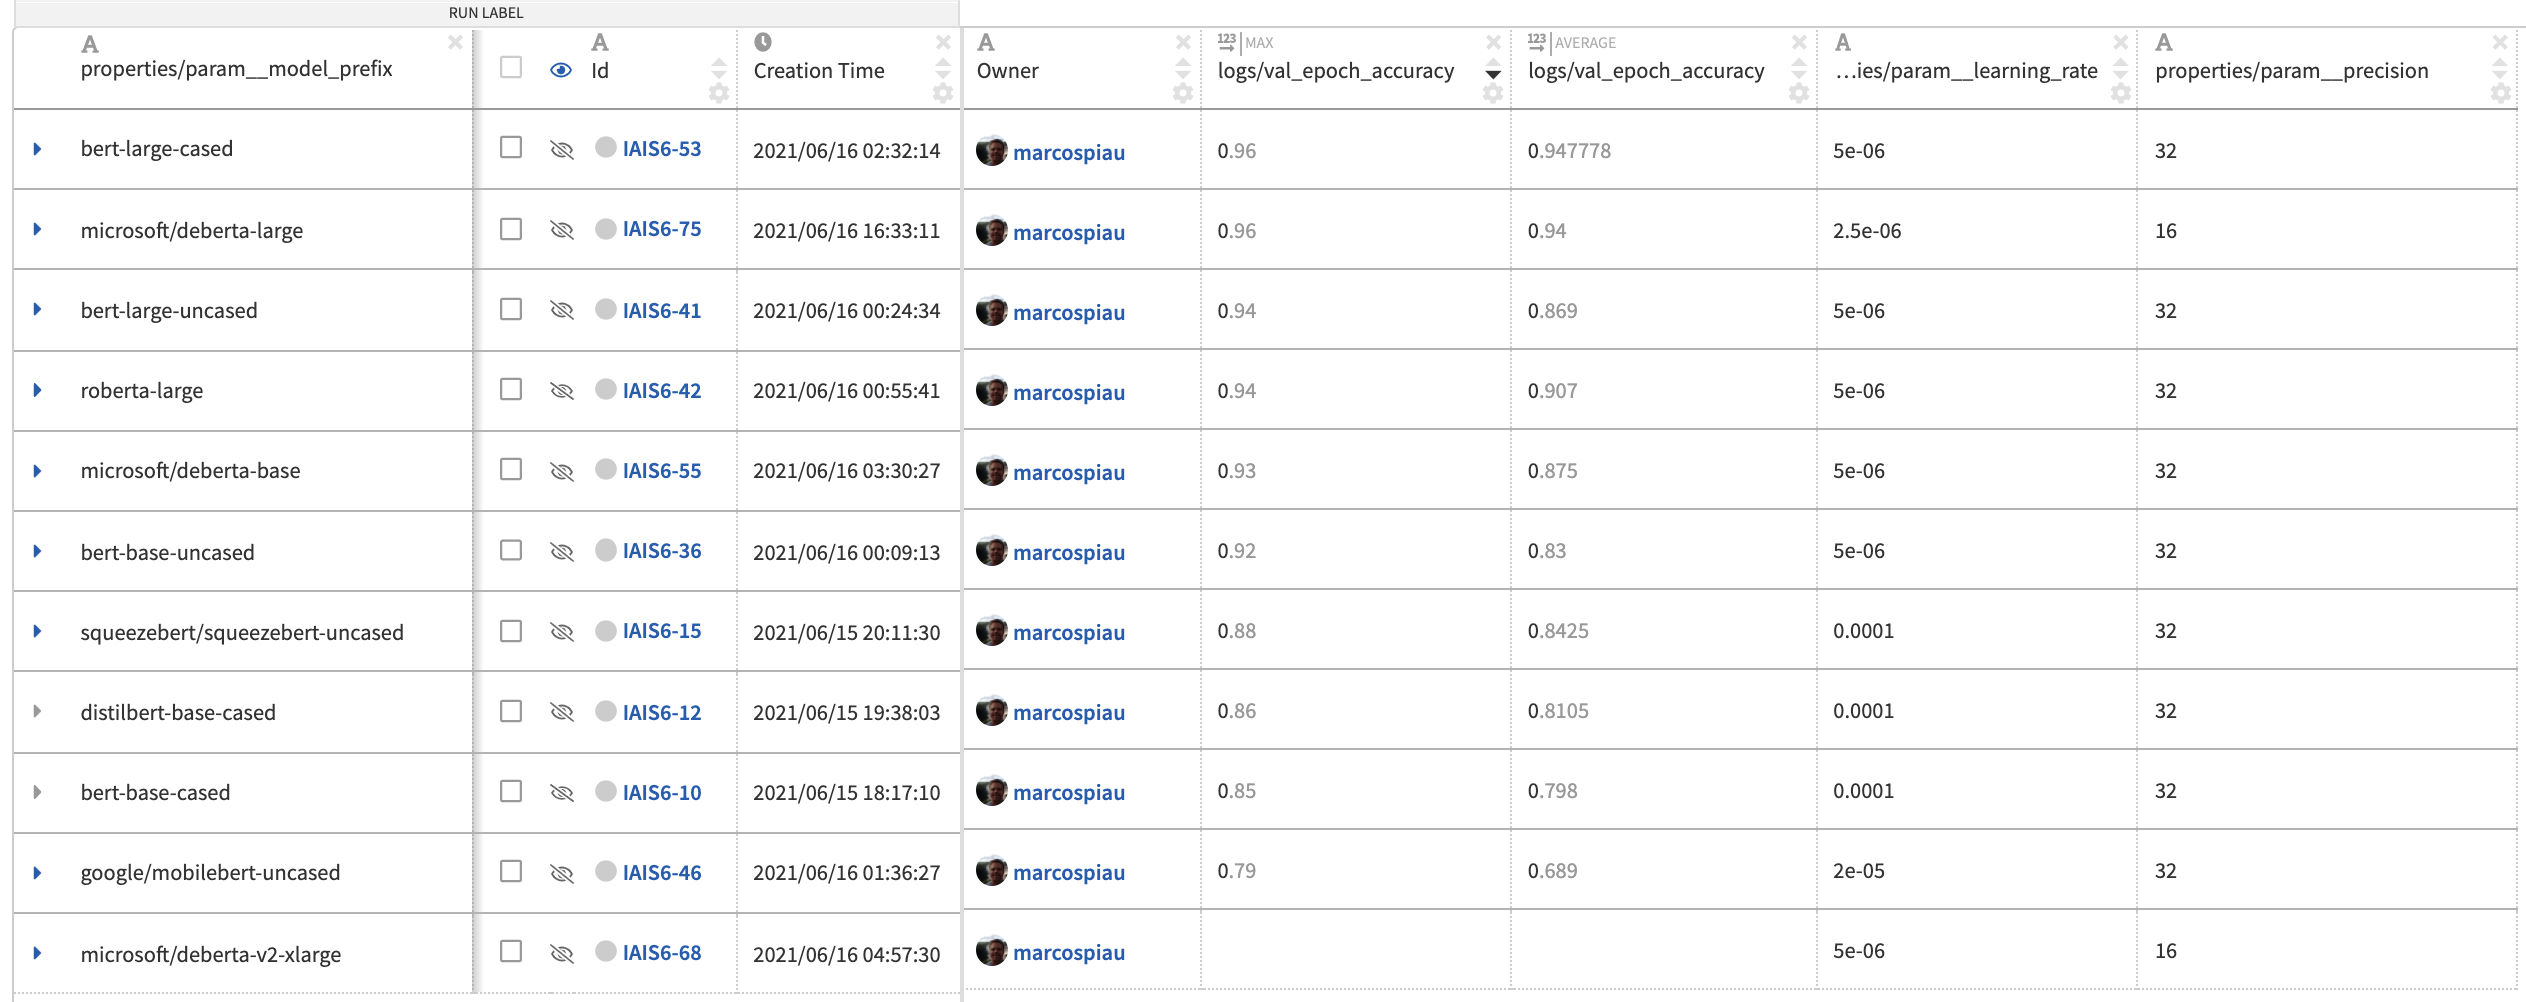

## Avalia métricas no teste para o modelo com melhor métrica na validação

Como esperado, os modelos com maior número de parâmetros ficaram com melhor desempenho. Os modelos `bert-large-cased` `microsoft/deberta-large` ficaram com desepmenho bem próximo (0.96 de acurácia na validação), mas escolhi o `microsoft/deberta-large` porque ele foi treinado somente em uma vez, precisando de 7 epochs para atingir o melhor resultado; o `bert-large-cased` precisou de 15 (peguei o checkpoint de 5 épocas e treinei por mais 10).

Com certeza as escolha de hiperparâmetros influencia nos resultados, mas os experimentos com o `microsoft/deberta-large` convergem bem rápido; no primeiro experimento com esse modelo consegui 0.95 de acurácia na validação com apenas duas epochs de treino.

O melhor modelo possui os hiperperâmetros abaixo:
 - 'microsoft/deberta-large'
 - learning_rate de 3e-6
 - batch size virtual de 32 (batch_size=2, accumulate_grad_batches=16)
 - modelo treinado com um máximo de 10 epochs, atingindo o valor máximo de acurácia de 0.96 na validação na epoch 6 (7 épocas).

Avaliando teste no experimento escolhido https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-11/e/IAIS6-72/charts:

In [ ]:
BEST_CKPT = os.path.join(CKPT_DIR, 'exp_uuid=c3d36aa5-af91-420a-bb1d-977cb357ee15-epoch=6-train_epoch_f1=0.0000-train_epoch_accuracy=0.9814-val_epoch_f1=0.0000-val_epoch_accuracy=0.9600.ckpt')
!ls -lht {BEST_CKPT}

-rw------- 1 root root 4.6G Jun 16 17:53 '/content/drive/MyDrive/IA376I_1S2021/aula_11/checkpoints/exp_uuid=c3d36aa5-af91-420a-bb1d-977cb357ee15-epoch=6-train_epoch_f1=0.0000-train_epoch_accuracy=0.9814-val_epoch_f1=0.0000-val_epoch_accuracy=0.9600.ckpt'


Métricas em todas partições:

In [ ]:
%%time
model = load_checkpoint(LitAutoClassifier,BEST_CKPT)
trainer = pl.Trainer(gpus=1)

print('train')
trainer.test(model, train_dataloader)
print('val')
trainer.test(model, val_dataloader)
print('test')
trainer.test(model, test_dataloader)

Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaForSequenceClassification: ['config', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-large and are newly initialized: ['classifier.bias',

train


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_epoch_accuracy': 0.9842857122421265,
 'test_epoch_loss': 0.04659448191523552}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


val



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_epoch_accuracy': 0.9599999785423279,
 'test_epoch_loss': 0.13317662477493286}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


test



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_epoch_accuracy': 0.9449999928474426,
 'test_epoch_loss': 0.19193153083324432}
--------------------------------------------------------------------------------
CPU times: user 1min 14s, sys: 45.3 s, total: 1min 59s
Wall time: 3min 3s


# Plots pyeer

## Define funções:

In [ ]:
import pyeer
from pyeer import eer_info
def calc_eer_stats(y_true, y_score):
    """Calcula estísticas EER usando o pyeer.

    Args:
        y_true: rótulos ground-truth (0 ou 1)
        y_score: scores contínuos preditos.
    
    Returns:
        pyeer.eer_stats.Stats namedtuple com estatísticas err.

    """
    # genuine scores: scores para classe genuína (1)
    gen_scores = y_score[y_true == 1]
    # impostor scores: classe impostora (0)
    imp_scores = y_score[y_true == 0]
    stats = eer_info.get_eer_stats(gen_scores=gen_scores, imp_scores=imp_scores)
    return stats

def pyeer_compare_train_val_test(model, train_dataloader, val_dataloader,
                                 test_dataloader):
    """Faz plots comparativos do pyeer para treino, validação e teste."""
    loaders = {
        'train': train_dataloader,
        'val': val_dataloader,
        'test': test_dataloader
        }

    preds = {
        k: concat_by_common_keys(trainer.predict(model, v))
        for k,v in loaders.items()
    }

    for k,v in preds.items():
        preds[k] = (v['labels'].cpu().numpy().ravel(), v['probs'][:,1].cpu().numpy())

    stats_dict = {
        k: calc_eer_stats(v[0],v[1])
        for k,v in preds.items()
    }

    pyeer.plot.plot_eer_stats(
        stats=list(stats_dict.values()),
        ids=list(stats_dict.keys()),
        save_plots=False)

## Modelo final escolhido - `microsoft/deberta-large`

Conforme já citado acima, kráficos do Neptune estão em https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-11/e/IAIS6-72/charts.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your predict_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


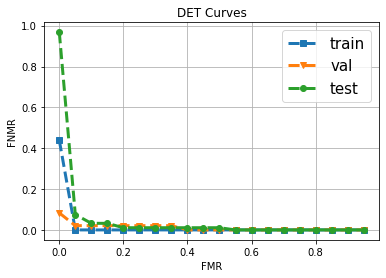

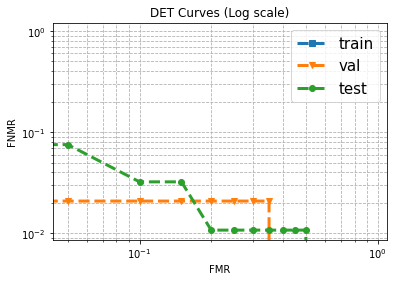

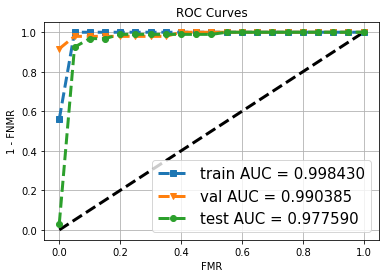

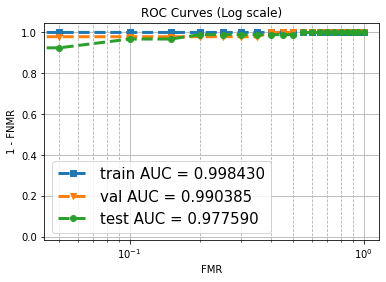

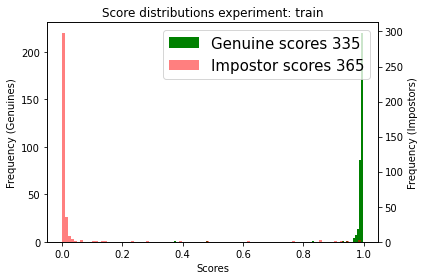

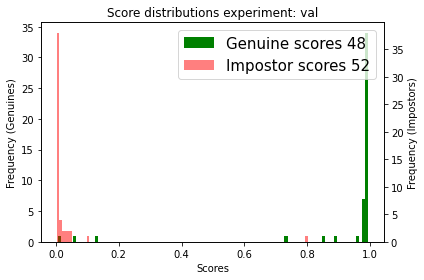

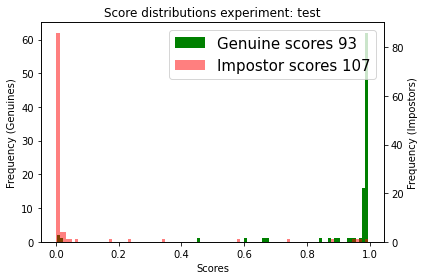

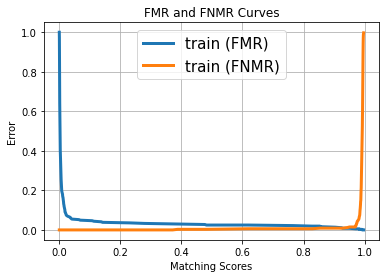

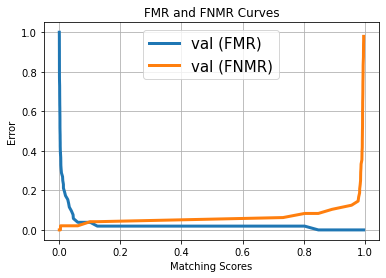

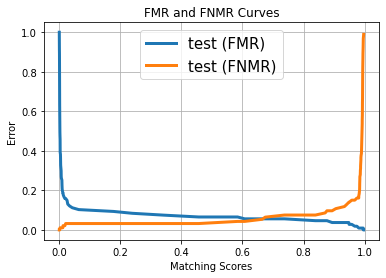

In [ ]:
pyeer_compare_train_val_test(model, train_dataloader, val_dataloader, test_dataloader)

## Melhor modelo escolhido anteriormente - `bert-large-cased`

Esse modelo é o que eu havia escolhido antes de fazer os treinamentos com o `microsoft/deberta-large`. Os gráficos no Neptune podem ser encontrados em https://app.neptune.ai/marcospiau/ia376i-1s2021-aula-11/e/IAIS6-53/charts.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your predict_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


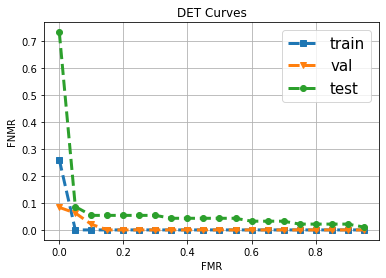

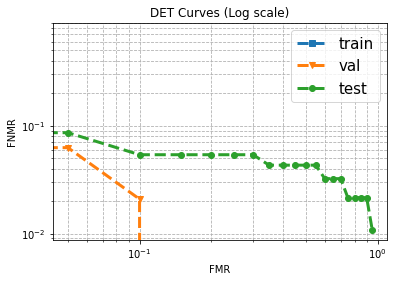

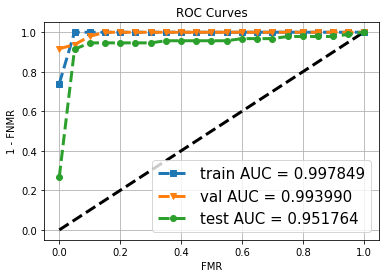

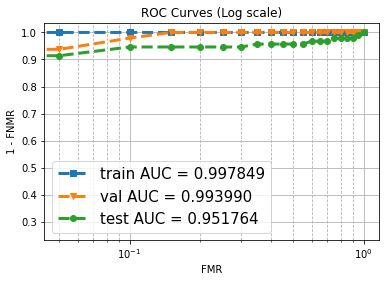

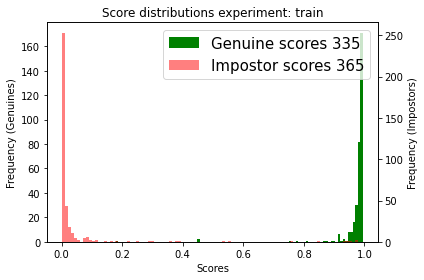

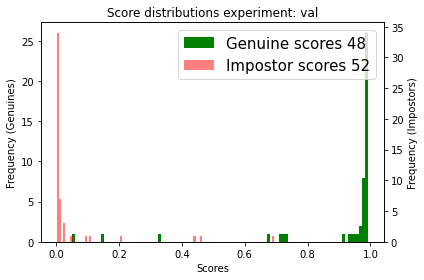

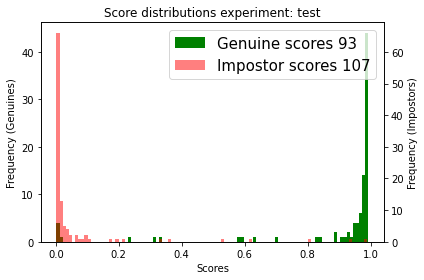

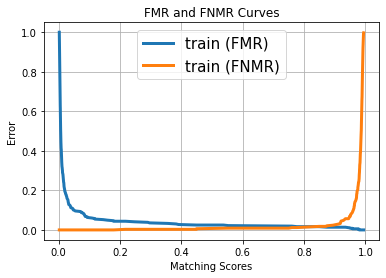

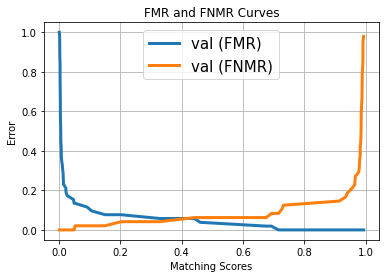

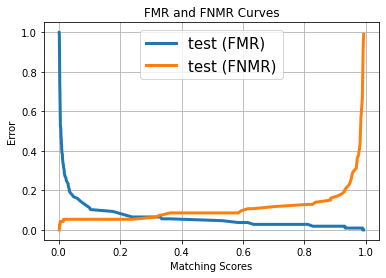

In [ ]:
pyeer_compare_train_val_test(model, train_dataloader, val_dataloader, test_dataloader)

## Gráfico com Glove e atenção simplificada (aula 10):

100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


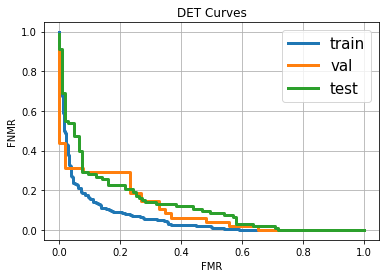

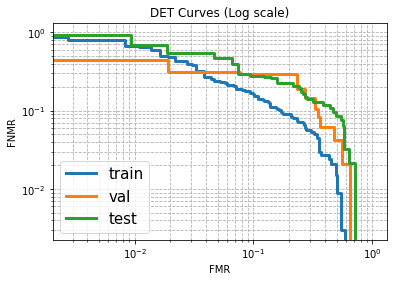

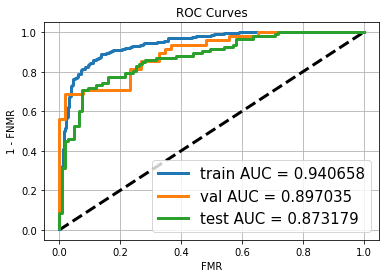

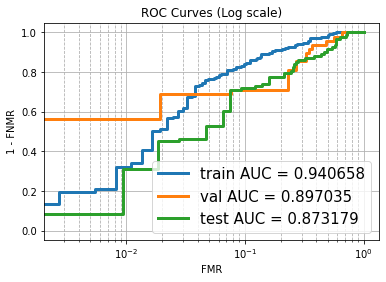

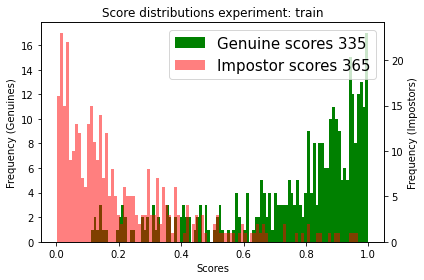

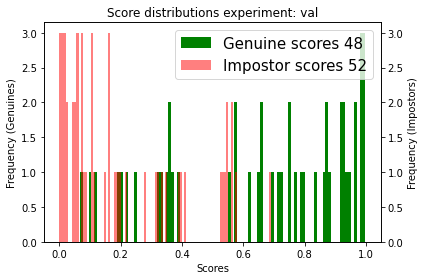

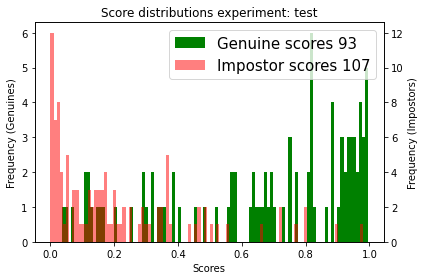

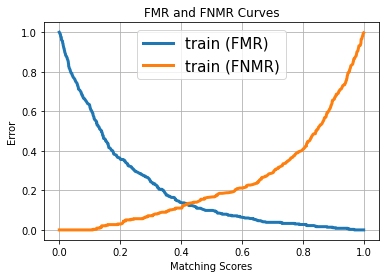

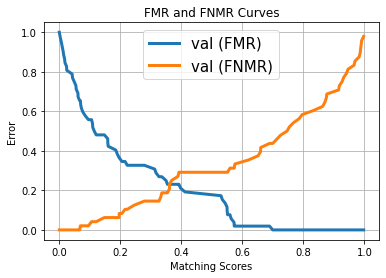

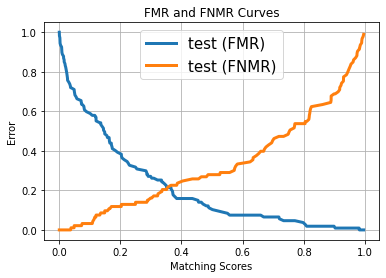

In [ ]:
pyeer_compare_train_val_test(model, train_dataloader, val_dataloader, test_dataloader)

In [ ]:
del model, trainer, BEST_CKPT
torch.cuda.empty_cache()
gc.collect()

50987

## Comentários plots pyeer

Podemos ver que a distribuição de score é bem melhor para os modelos pré-treinados, quando comparamos com modelo de auto-atenção da aula 10.

Podemos ver que o `bert-large-uncased` tem uma distribuição de scores pior, com alguns exemplos de classificacão positiva com scores próximos de zero, o que não ocorre no `microsoft/deberta-large` o que é menor Isso também se reflete nos gráficos de ERR e AUC.

# Melhorias futuras

- função predict dentro do módulo Lightning: gastei bastante tempo, mas não ficou exatamente como eu queria porque ainda precisa concatenar os resultados por fora
- testar mais formas de regularização
- criar função pra pegar o nome do checkpoint dado o nome do experimento no Neptune
- salvar checkpoint no drive toda epoch deixa mais lento, talvez dê pra subir apenas ao fim do treino
- usar early stopping pra fazer experimentos mais rápidos
- testar mais estratégias de otimização (outros otimizadores, schedulers etc)
- talvez usar ginconfig ao invés de argparser pra conseguir configurar mais coisas
- colocar train step accuracy (coloquei somente no final do batch). Talvez usar as funções do torchmetrics ajude nesse sentido
- arrumar código pra quando for partir de checkpoint, do jeito que está ele ignora os checkpoints que já foram salvos porque começa um uuid diferente
- acredito que dá pra aumentar os batch sizes na hora do teste, ajudaria a acelerar as predições
- interface de treino do huggingface parece ser legal, mas teria que adaptar o que já sei do Lighthing

# Conclusão / comentários finais

- precisamos usar learning rate baixo (1e-3 não conseguiu fazer o modelo aprender)
- foi necessário usar um batch size pequeno e acúmulo de gradientes para conseguirmos treinar os modelos, ainda mais para os modelos large
- só conseguir usar `float16` no último dia: estava tendo um erro devido ao fato de fazer softmax dos logits com `bfloat16`, converter para float antes resolveu
- Pytorch Lightning e Hugging Face são excelentes bibliotecas, mas o tempo gasto conseguindo fazer tudo funcionar é considerável
- usar a interface `Auto` do HuggingFace facilita bastante a experimentação, pois basicamente precisamos mudar apenas o nome do modelo a ser usado.
- assinei colab pro ao fim do exercício, facilitou muito para conseguir treinar modelos maiores e também ter mais cota para treinar sem levar "castigo"; além disso é possível usar um terminal no Colab, o que possibilita o uso de scripts ao invés de notebook